In [15]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms
from PIL import Image
import torchkbnufft as tkbn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Text(0, 0.5, 'v')

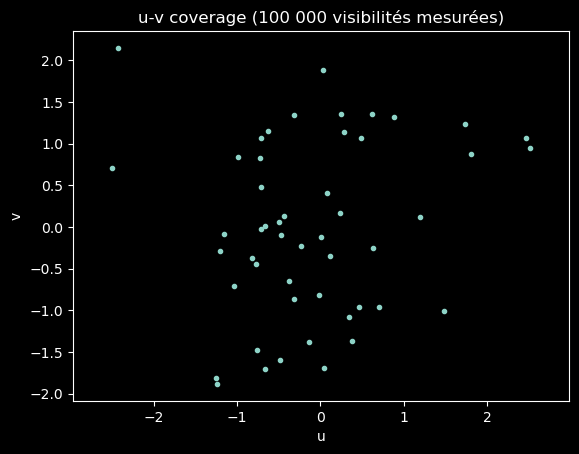

In [16]:
uv = torch.randn((50, 2))
plt.plot(uv[:, 0], uv[:, 1], ".")
plt.axis("equal")
plt.title("u-v coverage (100 000 visibilités mesurées)")
plt.xlabel("u")
plt.ylabel("v")

In [17]:
int(1.5 * 28)

42

In [18]:
dataset = torch.load("../../MNIST_torch/test_images.pt")
DEVICE = "cpu"
img = dataset[84].reshape(1, 1, 28, 28).to(DEVICE)
pixels = 28
def nufft_forward(im, uv_points, smaps=None):
    nufft = tkbn.KbNufft(im_size=[pixels, pixels], device=DEVICE, numpoints=5, grid_size=[int(1.5*pixels), int(1.5*pixels)], table_oversamp=1)
    return nufft.forward(im.cfloat(), uv_points.t(), smaps=smaps, norm = None)/pixels  # By definition

def dirty_image(vis, uv_points, grid_size, smaps=None):
    dcomp = tkbn.calc_density_compensation_function(uv_points.T, grid_size)
    inv_fft = tkbn.KbNufftAdjoint(im_size=grid_size, grid_size=[int(1.5*n) for n in grid_size], device=DEVICE, numpoints=5, table_oversamp=1)
    return inv_fft.forward(vis * dcomp, uv_points.T, smaps=smaps)

In [19]:
nufft_forward(img, uv)

tensor([[[-0.1092+0.6887j,  0.0088-0.3666j,  0.1491-0.0212j, -0.6667+0.0989j,
          -0.6981-0.3949j,  0.0138-0.2738j,  0.3277+0.1373j,  0.0523+0.0568j,
          -0.1382+0.3325j, -0.1198-0.2995j, -0.2893+0.2575j, -0.0450+0.0058j,
           0.1422-0.1164j, -2.1401+1.0552j, -0.0408+0.0760j, -0.1395+1.7092j,
          -0.0762+0.3538j,  0.4461+0.1946j,  0.1548-0.4473j,  0.1130+0.2105j,
          -0.0203+0.0870j, -0.3036+0.2356j, -0.1137+0.2424j,  0.2009+0.0442j,
          -0.0394+0.1788j, -0.1326+0.1975j,  0.9403+0.2729j, -0.2271+0.2144j,
          -0.2805-0.0367j, -0.4209+0.5264j, -0.6745-0.1034j, -0.3104+0.3239j,
           0.3628+0.7504j,  0.0871+0.0096j,  0.2203+0.0064j,  0.1723-0.1550j,
           0.0296+0.0283j,  0.0998+0.1087j, -0.5110+0.1516j,  0.0917+0.1562j,
          -0.1790-0.5431j,  0.8670-0.2654j,  0.7725+0.1251j,  0.2441+0.4864j,
          -0.0219-0.1791j, -1.3773+0.4006j, -0.0237+0.2667j, -0.2847-0.0167j,
           0.7995+0.3093j,  0.3208-0.3063j]]])

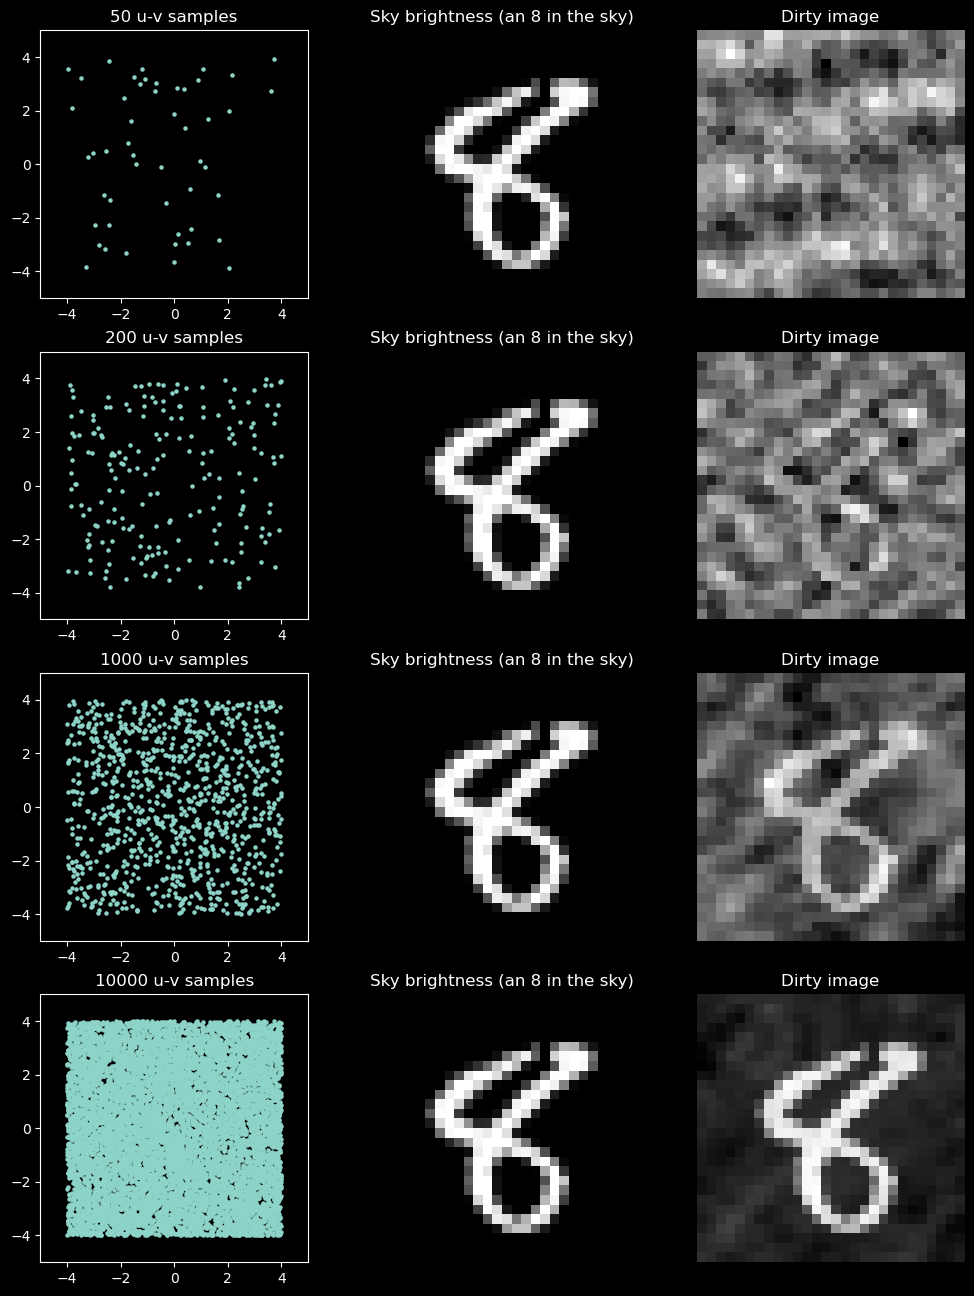

In [20]:

n_rows = 4
plt.style.use("dark_background")
fig, axs = plt.subplots(nrows = n_rows, ncols = 3, figsize = (3*4, 4*n_rows))


N = [0, 50, 200, 1000, 10000]
for i in range(1, 5):
    num_points = N[i] 
    uv = torch.empty((num_points, 2)).uniform_(-4, 4)
    img = img.to(DEVICE)
    uv = uv.to(DEVICE)
    visibility = nufft_forward(img, uv)
    reconstructed_img = dirty_image(visibility, uv, [28, 28])
    visibility = visibility[0,0,...]
    axs[i-1, 0].scatter(uv[:, 0], uv[:,1], s = 5)
    axs[i-1, 0].set(aspect = "equal", xlim = (-5, 5), ylim = (-5, 5), title  = f"{num_points} u-v samples")

    axs[i-1, 1].imshow(img[0, 0, ...].cpu(), cmap = "gray")
    axs[i-1, 1].axis("off")
    axs[i-1, 1].set_title("Sky brightness (an 8 in the sky)")

    axs[i-1, 2].imshow(reconstructed_img[0,0, ...].cpu().real, cmap = "gray")
    axs[i-1, 2].axis("off")
    axs[i-1, 2].set_title("Dirty image")



## Gridding to get the visibility 

In [21]:
dataset = torch.load("../../MNIST_torch/test_images.pt")

Shape $V(u,v)$ = output of the $FFT(I)$, (28, 28) for MNIST

In [22]:
img = dataset[84].reshape(28, 28)
visibility = torch.fft.fft2(img).flatten()
# Creating a grid with the same size as the visibility grid: 
u, v = torch.meshgrid([torch.arange(-6.75, 6.76, 0.5), torch.arange(6.75, -6.76, -0.5)], indexing = "xy")
uv_coords = torch.stack([u.flatten(), v.flatten()]).t()
print(uv_coords.shape)

torch.Size([784, 2])


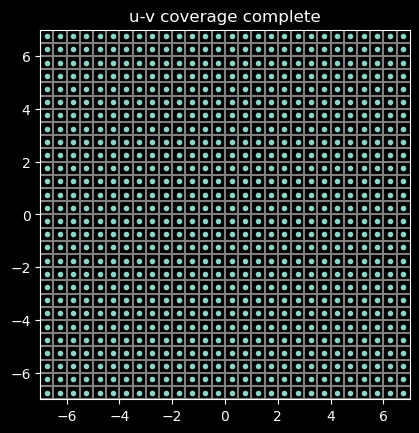

In [23]:
plt.plot(uv_coords[:, 0], uv_coords[:, 1], ".")
plt.gca().set_aspect("equal")
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.title("u-v coverage complete")
for i in range(28): 
    plt.axvline(-7 + i * 0.5, color = "grey")
    plt.axhline(-7 + i * 0.5, color = "grey")

In [24]:
# Getting rid of some points in this u-v coverage: 
p = 0.5
coords = torch.bernoulli(p * torch.ones(784)).to(torch.bool)
uv_coords = uv_coords[coords] 
visibility_coverage = visibility.flatten()

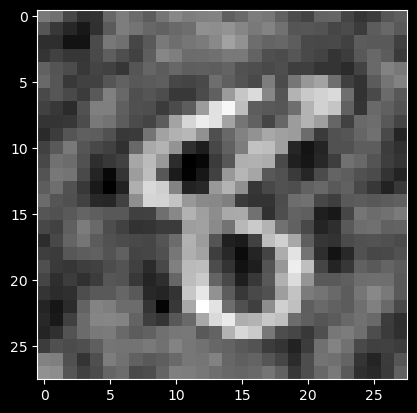

In [25]:
plt.imshow(torch.fft.ifft2((visibility_coverage * coords).reshape(28, 28)).real, cmap = "gray")

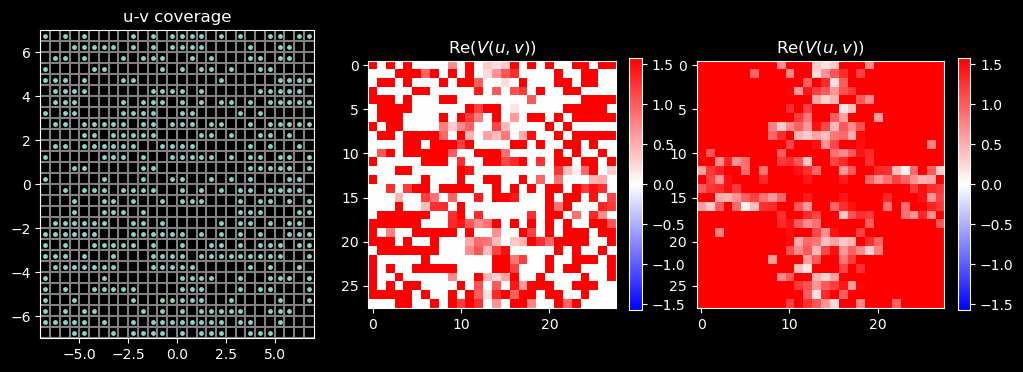

In [26]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
axs[0].scatter(uv_coords[:, 0], uv_coords[:, 1], s = 6)

axs[0].set_xlim([-7, 7])
axs[0].set_ylim([-7, 7])
axs[0].set_title("u-v coverage")
for i in range(28): 
    axs[0].axvline(-7 + i * 0.5, color = "grey")
    axs[0].axhline(-7 + i * 0.5, color = "grey")

im = axs[1].imshow((visibility * coords).reshape(28, 28).abs(), cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[1].set_title(r"Re($V(u,v)$)")
plt.colorbar(im, fraction = 0.046)

im = axs[2].imshow((visibility).reshape(28, 28).abs(), cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[2].set_title(r"Re($V(u,v)$)")
plt.colorbar(im, fraction = 0.046)

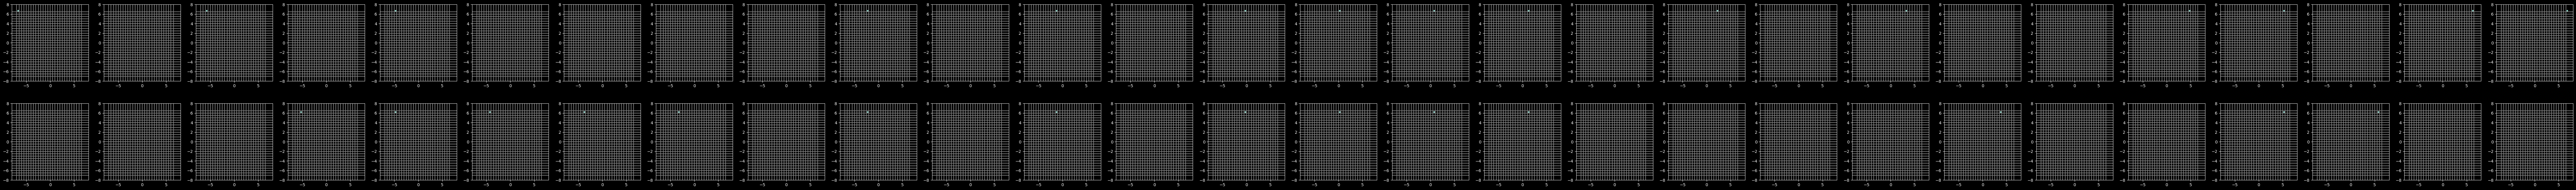

In [27]:
num_cells = 28
n_rows = 2
fig, axs = plt.subplots(n_rows, 28, figsize = (28 * 4, n_rows * 4))
fov = 14
pixel_scale = fov/num_cells

for i in range(n_rows):
    for j in range(num_cells):
        coords = torch.where((uv_coords[:, 0]>-fov/2 + j * pixel_scale ) & (uv_coords[:, 0]<-fov/2 + (j+1) * pixel_scale) & (uv_coords[:, 1]<fov/2 - i * pixel_scale ) & (uv_coords[:, 1]>fov/2 - (i+1) * pixel_scale))[0]
        axs[i, j].plot(uv_coords[coords][:, 0], uv_coords[coords][:, 1], ".")
        axs[i, j].set_xlim([-8, 8])
        axs[i, j].set_ylim([-8, 8])
        axs[i, j].set_aspect("equal")
        for k in range(28): 
            axs[i, j].axvline(-7 + k * 0.5, color = "grey")
            axs[i, j].axhline(-7 + k * 0.5, color = "grey")

Now we use the u-v coverage to see where in our visibility grid there are measurements

First, let's try to use the full complete u-v coverage to do this and see if we can reconstruct the image

In [28]:
num_cells = 28
fov = 14
pixel_scale = fov / num_cells
visibility_grid = torch.zeros(size = (784,), dtype = torch.complex64)

k = 0
for i in range(num_cells): 
    for j in range(num_cells):
        vis_coords = torch.where((uv_coords[:, 0]>-fov/2 + j * pixel_scale ) & (uv_coords[:, 0]<-fov/2 + (j+1) * pixel_scale) & (uv_coords[:, 1]>fov/2 - (i+1) * pixel_scale ) & (uv_coords[:, 1]<fov/2 - (i) * pixel_scale))[0]
        if len(vis_coords) == 0: 
            visibility_grid[k] = 0
        else: 
            vis_coords = vis_coords.item()
            visibility_grid[k] =  visibility[k] 
        k += 1

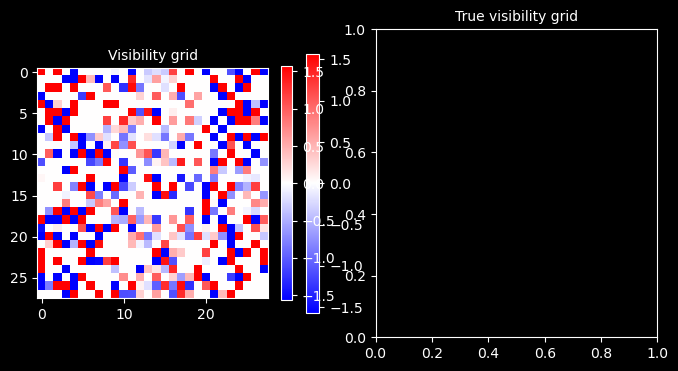

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
im = axs[0].imshow(visibility_grid.reshape(28, 28).real, cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[0].set_title("Visibility grid", fontsize = 10)
plt.colorbar(im, fraction = 0.046)
#im = axs[1].imshow((visibility * coords).reshape(28, 28).real, cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[1].set_title("True visibility grid", fontsize = 10)
plt.colorbar(im, fraction = 0.046)


In [31]:
img.shape

torch.Size([28, 28])

In [32]:
visibility_nufft = nufft_forward(img[None, None, ...], uv_coords)
dirty = dirty_image(visibility_nufft, uv_coords, [28, 28])

(-0.5, 27.5, 27.5, -0.5)

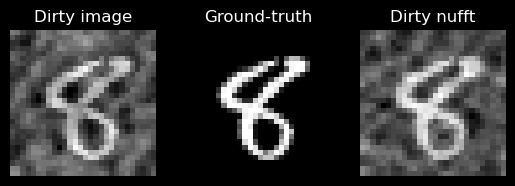

In [38]:
reconstructed_img = torch.fft.ifft2(visibility_grid.reshape(28, 28))
fig, axs = plt.subplots(1, 3, )

axs[0].imshow(reconstructed_img.real, cmap = "gray")
axs[0].set_title("Dirty image")
axs[0].set_aspect("equal")
axs[0].axis("off")

axs[1].imshow(img, cmap = "gray")
axs[1].set_title("Ground-truth")
axs[1].set_aspect("equal")
axs[1].axis("off")

axs[2].imshow(dirty[0, 0].real, cmap = "gray")
axs[2].set_title("Dirty nufft")
axs[2].set_aspect("equal")
axs[2].axis("off")

#### Gridding with random uv samples in the grid and doing a sort of weighting to each visibility corresponding to the samples 

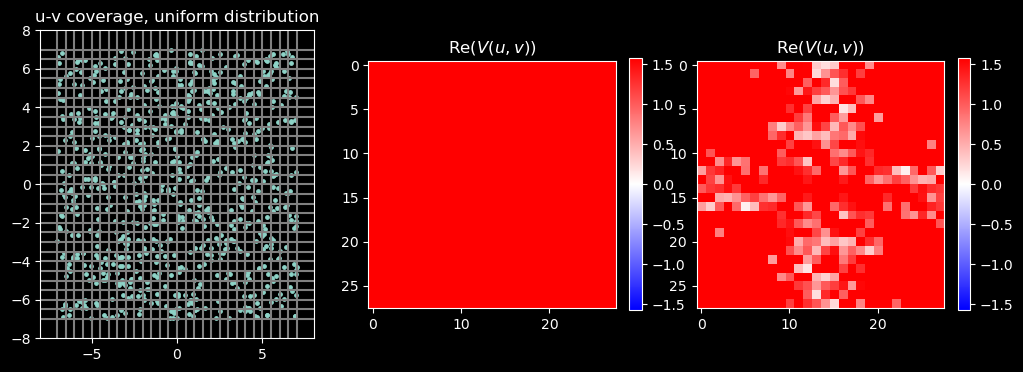

In [26]:
uv_coords = torch.empty(size = [784, 2]).uniform_(-7, 7)
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
axs[0].scatter(uv_coords[:, 0], uv_coords[:, 1], s = 6)

axs[0].set_xlim([-8, 8])
axs[0].set_ylim([-8, 8])
axs[0].set_title("u-v coverage, uniform distribution")
for i in range(29): 
    axs[0].axvline(-7 + i * 0.5, color = "grey")
    axs[0].axhline(-7 + i * 0.5, color = "grey")

im = axs[1].imshow((visibility * coords).reshape(28, 28).abs(), cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[1].set_title(r"Re($V(u,v)$)")
plt.colorbar(im, fraction = 0.046)

im = axs[2].imshow((visibility).reshape(28, 28).abs(), cmap = "bwr", vmin = -torch.pi/2, vmax = torch.pi/2)
axs[2].set_title(r"Re($V(u,v)$)")
plt.colorbar(im, fraction = 0.046)

We have one uv sample per visibility for now (next we'll remove some uv samples to lose information)

In [60]:
num_cells = 28
fov = 14
pixel_scale = fov / num_cells
visibility_grid = torch.zeros(size = (784,), dtype = torch.complex64)

k = 0
for i in range(num_cells): 
    for j in range(num_cells):
        vis_coords = torch.where((uv_coords[:, 0]>-fov/2 + j * pixel_scale ) & (uv_coords[:, 0]<-fov/2 + (j+1) * pixel_scale) & (uv_coords[:, 1]>fov/2 - (i+1) * pixel_scale ) & (uv_coords[:, 1]<fov/2 - (i) * pixel_scale))[0]
        if len(vis_coords) == 0: 
            visibility_grid[k] = 0
        else: 
            #vis_coords = vis_coords.item()
            visibility_grid[k] =  visibility[vis_coords].mean() 
        k += 1

(-0.5, 27.5, 27.5, -0.5)

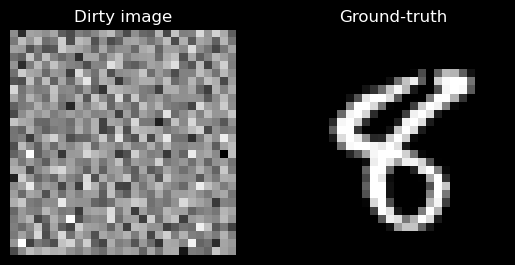

In [61]:
reconstructed_img = torch.fft.ifft2(visibility_grid.reshape(28, 28))
fig, axs = plt.subplots(1, 2)

axs[0].imshow(reconstructed_img.real, cmap = "gray")
axs[0].set_title("Dirty image")
axs[0].set_aspect("equal")
axs[0].axis("off")

axs[1].imshow(img, cmap = "gray")
axs[1].set_title("Ground-truth")
axs[1].set_aspect("equal")
axs[1].axis("off")

In [35]:
vis_coords

tensor([508, 535])

In [37]:
visibility[vis_coords].mean()

tensor(-3.6564+0.6956j)

In [30]:
uv_coords[85]

tensor([-0.8283, -1.5428])

In [28]:
len(uv_coords)

784

In [9]:
rho = torch.sqrt(uv[:, 0] ** 2 + uv[:,1] ** 2)
fov = round(rho.max().item())
pixel_scale = round(rho.min().item(), 2)
print(fov, pixel_scale) # Rad/pixel

4 0.02


In [34]:
fov = 4
pixel_scale = 0.25

In [36]:
num_cells = 2* int(4/0.25)
num_cells

32

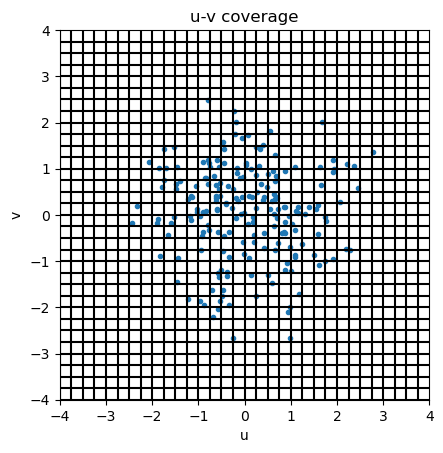

In [78]:
# Just viewing the gridding: 
plt.style.use("default")
plt.plot(uv[:, 0].cpu(), uv[:, 1].cpu(), ".")
plt.title("u-v coverage")
plt.xlabel("u")
plt.ylabel("v")

for i in range(num_cells): 
    plt.axvline(-fov + i * pixel_scale, color = "k")
    plt.axhline(-fov + i * pixel_scale, color = "k")


plt.xlim([-fov, fov])
plt.ylim([-fov, fov])
plt.gca().set_aspect('equal', adjustable = "box")


In [ ]:
visibility_grid = torch.zeros(size = (num_cells, num_cells))

In [82]:
for i in range(num_cells):
    for j in range(num_cells):
        

200

In [22]:
torch.tensor([True, False]) + torch.tensor([True, False])

tensor([ True, False])

In [80]:
torch.sum((uv[:,0]<-1) + (uv[:,1]<-1))

tensor(57, device='cuda:0')

In [14]:
coords_min = 
coords_max = uv.max(dim = 0)[0]

In [14]:
coords_max

tensor([2.8456, 3.3214])

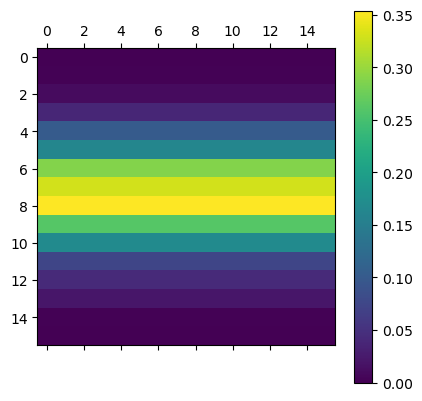

In [15]:
coords_min = torch.tensor([-4, -4])
coords_max = torch.tensor([4, 4])
cell_size = 0.5
num_cells = np.ceil((coords_max - coords_min) / cell_size ).to(torch.int32)
grid = torch.zeros(size = num_cells.tolist())
# Filling the elements of the grid by the weighted sum over all the samples in the u-v coverage: 
cell_idx = ((uv-coords_min) / cell_size).to(torch.int32) # uv-coords_min > shift to the cell 0 and /cell_size to make sure that cell_size is the unit cell of the grid 
for idx in cell_idx: 
    grid[idx.tolist()] += 1/N

plt.matshow(grid)
plt.colorbar()

Non-uniform Kaiser-Bessel interpolation layer.

This object interpolates a grid of Fourier data to off-grid locations
using a Kaiser-Bessel kernel. Mathematically, in one dimension it estimates
$Y_m, m \in [0, ..., M-1]$ at frequency locations $\omega_m$
from $X_k, k \in [0, ..., K-1]$, the oversampled DFT of
$x_n, n \in [0, ..., N-1]$. To perform the estimate, this layer
applies


$$ Y_m = \sum_{j=1}^J X_{\{k_m+j\}_K}u^*_j(\omega_m)$$

where $u$ is the Kaiser-Bessel kernel, $k_m$ is the index of
the root offset of nearest samples of $X$ to frequency location
$\omega_m$, and $J$ is the number of nearest neighbors to use
from  $X_k$. Multiple dimensions are handled separably. For a
detailed description of the notation see
[Nonuniform fast Fourier transforms using min-max interpolation
(JA Fessler and BP Sutton)](https://doi.org/10.1109/TSP.2002.807005).

When called, the parameters of this class define properties of the kernel
and how the interpolation is applied.

* :attr:`im_size` is the size of the base image, analagous to :math:`N`
  (used for calculating the kernel but not for the actual operation).

* :attr:`grid_size` is the size of the grid prior to interpolation,
  analogous to :math:`K`. To reduce errors, NUFFT operations are done on an
  oversampled grid to reduce interpolation distances. This will typically
  be 1.25 to 2 times :attr:`im_size`.

* :attr:`numpoints` is the number of nearest to use for interpolation,
  i.e., :math:`J`.

In [39]:
torch.ones(2)

tensor([1., 1.])

In [130]:
uv[0]

tensor([1.4489, 0.0058])

In [133]:
idx[0].tolist()

[8, 6]

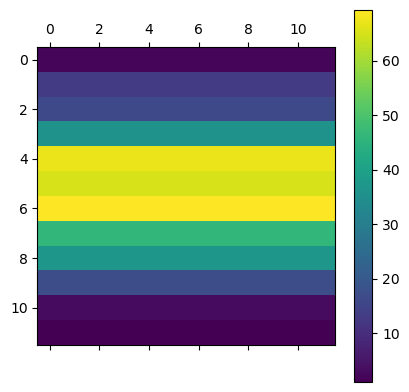

In [48]:
fov = 4
cell_size = 0.25

In [51]:
uv[:, 0]< -fov + i * 0.25

tensor([False, False, False,  True,  True,  True, False, False,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True, False,
         True, False, False, False,  True, False,  True, False,  True,  True,
        False, False,  True, False, False,  True,  True, False, False,  True,
         True,  True, False,  True,  True, False,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
        False,  True,  True, False,  True, False,  True, False, False,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True, False,  True, False, False,
         True,  True, False,  True,  True,  True,  True,  True, 

In [50]:
uv[:, 0].min()

tensor(-2.3434)

In [39]:
grid = torch.empty(size = (int(fov//pixel_scale), int(fov//pixel_scale)))

In [41]:
uv.shape

torch.Size([200, 2])

In [43]:
fov

4

In [ ]:
torch.where()

In [99]:
import numpy as np

def grid_coordinates(xy, grid_size):
    # Calculate the minimum and maximum coordinates
    min_coord = np.min(xy, axis=0)
    max_coord = np.max(xy, axis=0)

    # Calculate the number of grid cells in each dimension
    num_cells = np.ceil((max_coord - min_coord) / grid_size).astype(int)

    # Create an empty grid to store the counts in each cell
    grid = np.zeros(num_cells)

    # Compute the indices of the cells for each coordinate
    cell_indices = ((xy - min_coord) / grid_size).astype(int)

    # Count the number of coordinates in each cell
    for idx in cell_indices:
        grid[tuple(idx)] += 1

    return grid

# Example usage
xy = np.random.rand(200, 2)  # Random set of 200 coordinates
grid_size = 0.1  # Size of each grid cell

grid = grid_coordinates(xy, grid_size)
print(grid)

[[0. 1. 0. 5. 3. 0. 3. 1. 4. 1.]
 [0. 0. 4. 1. 4. 3. 5. 2. 4. 1.]
 [0. 7. 5. 1. 1. 3. 1. 2. 0. 0.]
 [4. 4. 3. 4. 4. 2. 2. 5. 1. 1.]
 [1. 3. 4. 1. 2. 2. 2. 0. 2. 1.]
 [3. 0. 1. 1. 1. 2. 3. 0. 0. 2.]
 [4. 3. 1. 3. 1. 1. 2. 1. 3. 4.]
 [2. 1. 2. 1. 1. 0. 2. 3. 3. 2.]
 [3. 0. 1. 3. 1. 3. 0. 1. 2. 1.]
 [3. 2. 2. 3. 3. 3. 1. 2. 1. 2.]]


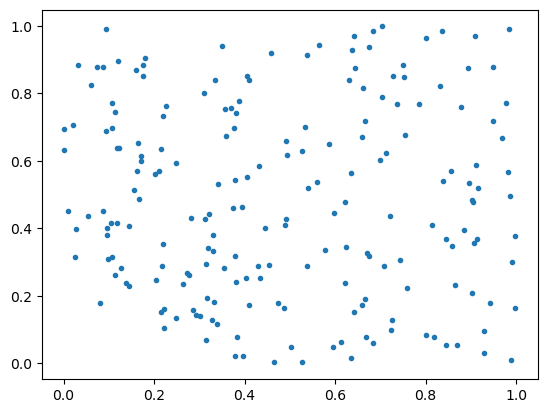

In [100]:
plt.plot(xy[:, 0], xy[:, 1], ".")

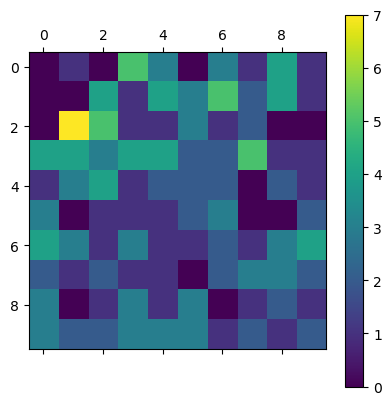

In [101]:
plt.matshow(grid)
plt.colorbar()

In [40]:
for i in range(grid.shape[0]): 
    for j in range(grid.shape[1]):
        grid[i, j] = 1/N * torch.sum(uv[i*pixel_scale, j * pixel_scale])

IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got float)

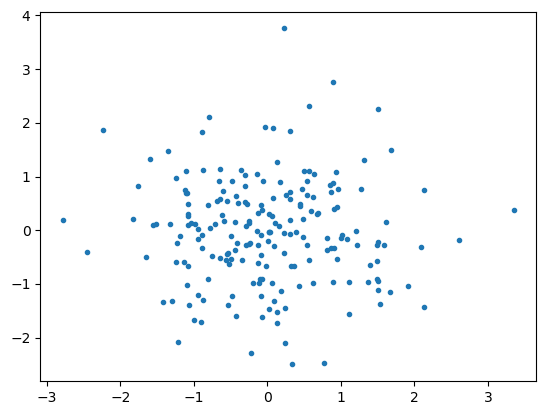

In [31]:
plt.plot(uv[:, 0], uv[:, 1], ".")

In [25]:
grid.shape

torch.Size([26, 26])

In [ ]:
# Gridding u-v plane: 
pixel_scale = 
fov = 
visibility_grid = 